# Import Libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from copy import deepcopy
import sklearn

import random

import glob
import xarray as xr

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# inpath is set for levante
def load_data(barents, mean, scenario1 = "ssp585", scenario2="ssp245",ensemble1 = "r1i1p1f1", ensemble2 = "r2i1p1f1", inpath = "/work/uo1227/u301557/DL/data/"):

    model = "MPI-ESM1-2-LR"
    if barents:
        month = 2
        SIA = xr.open_dataset(f"{inpath}/barents_sia/barents_sia_{model}_{ensemble1}_hist_{scenario1}.nc")
        SST = xr.open_dataset(f"{inpath}/barents_sst/barents_tos_{model}_{ensemble1}_hist_{scenario1}.nc")
        TAS = xr.open_dataset(f"{inpath}/barents_tas/barents_tas_{model}_{ensemble1}_hist_{scenario1}.nc")
        
        SIA_v = xr.open_dataset(f"{inpath}/barents_sia/barents_sia_{model}_{ensemble2}_hist_{scenario2}.nc")
        SST_v = xr.open_dataset(f"{inpath}/barents_sst/barents_tos_{model}_{ensemble2}_hist_{scenario2}.nc")
        TAS_v = xr.open_dataset(f"{inpath}/barents_tas/barents_tas_{model}_{ensemble2}_hist_{scenario2}.nc")
        
    else:
        month = 8
        SIA = xr.open_dataset(f"{inpath}/sia/sia_nh_{model}_{ensemble1}_hist_{scenario1}.nc")
        SST = xr.open_dataset(f"{inpath}/sst/tos_{model}_{ensemble1}_hist_{scenario1}.nc")
        TAS = xr.open_dataset(f"{inpath}/arctic_tas/arctic_tas_{model}_{ensemble1}_hist_{scenario1}.nc")
        
        SIA_v = xr.open_dataset(f"{inpath}/sia/sia_nh_{model}_{ensemble2}_hist_{scenario2}.nc")
        SST_v = xr.open_dataset(f"{inpath}/sst/tos_{model}_{ensemble2}_hist_{scenario2}.nc")
        TAS_v = xr.open_dataset(f"{inpath}/arctic_tas/arctic_tas_{model}_{ensemble2}_hist_{scenario2}.nc")
    
    if barents:
        sia  = SIA.sia_nh.isel(time=slice(12*start+month,-1,12)).values[:148,0,0] # cut off at 2100
        sia_v  = SIA_v.sia_nh.isel(time=slice(12*start+month,-1,12)).values[:148,0,0]
    else:
        sia  = SIA.sia_nh.isel(time=slice(12*start+month,-1,12)).values[:148]
        sia_v  = SIA_v.sia_nh.isel(time=slice(12*start+month,-1,12)).values[:148]
        
    sst_mean  = SST.tos.rolling(time=mean).mean().isel(time=slice(12*start+month-3,-1,12)).values[:,0,0] #select June
    sst  = SST.tos.isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    
    tas_mean = TAS.tas.rolling(time=mean).mean().isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    tas = TAS.tas.isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    
    tas_v_mean = TAS_v.tas.rolling(time=mean).mean().isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    tas_v = TAS_v.tas.isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    
    sst_v_mean  = SST_v.tos.rolling(time=mean).mean().isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    sst_v  = SST_v.tos.isel(time=slice(12*start+month-3,-1,12)).values[:,0,0]
    
    print(" sst ","  tas ","  sia ")
    print(sst.shape,tas.shape,sia.shape)
    
    print(str(SIA.time.values[12*start+month])[:10])
    print(str(SIA.time.values[12*(cut+start)+month])[:10])
    
    for ds in [SIA,SST,SIA_v,SST_v,TAS,TAS_v]: #
        ds.close()
        
    r1 = {"tas":tas, "tas_mean":tas_mean,"sst":sst,"sst_mean":sst_mean}
    r2 = {"tas":tas_v, "tas_mean":tas_v_mean,"sst":sst_v,"sst_mean":sst_v_mean}
        
    return r1,r2, sia, sia_v,SST

In [3]:
Barents_sea = False
start = 103
cut = 172-start
r1, r2, sia, sia_v,SST = load_data(Barents_sea, 12)

 sst    tas    sia 
(148,) (148,) (148,)
1953-09-16
2022-09-16


# Transform Data

## Normalize Data

In [4]:
def Norm(X):
    mean = np.nanmean(X)
    std  = np.nanstd(X)
    X = (X -mean)/std
    return X

def norm_sia(X):
    max  = np.expand_dims(np.nanmax(X,axis=1), axis=1)
    X = X/max
    X = torch.tensor(np.stack(X,axis=1), dtype=torch.float32)
    return X

def denorm_sia(x):
    x = x * max(sia)
    return x

## Define TimeSeriesDataset Class

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Combine Variables and Create the Datasets

In [6]:
def stacking(vars,w,dict): 
    """
    combines the different variables
    vars: variables to be combined
    w: window size
    dict: dictionary with data
    
    """
    data = []
    for var in vars:
        data.append(Window(var,w,dict))
    data = np.stack(data, axis=1)
    return torch.tensor(data, dtype=torch.float32)


def Window(var,w,dict): 
    """combines the staggered time information"""
    x = dict[var]
    x = Norm(x)
    data = []
    for i in range(w):
        data.append(x[i:-(w-i)])
        
    data = np.stack(data, axis=1)

    return data

def prep_data2(var,batch_size=8,w=4): 
    """
    calls stacking, splits the data and prepares the datasets 
    """
    if var == "both":
        X = stacking(["tas","tas_mean","sst","sst_mean"],w,r1)
        X_v = stacking(["tas","tas_mean","sst","sst_mean"],w,r2)
    else:
        X = stacking([var,var+"_mean"],w,r1)
        X_v = stacking([var,var+"_mean"],w,r2)

    y = norm_sia([sia[w:]])
    y_v = norm_sia([sia_v[w:]])

    X_train = X[:cut-w]
    X_test  = X[cut-w:]
    y_train = y[:cut-w]
    y_test  = y[cut-w:]
    X_valid = X_v[:cut]
    y_valid = y_v[:cut]

    hist = range(1850+start+w,2022)
    ssp  = range(2022,2101)

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #True
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
    return train_loader, test_loader, X_valid, y_valid, X_train, y_train, X_test, y_test, hist, ssp

# Plot Raw Data

In [7]:
def plot_raw_data(valid = False,save=False):
    
    if valid:
        data = r2
        data_sia = sia_v
    else:
        data = r1
        data_sia = sia
    
    fig = plt.figure(figsize=(12,3),tight_layout=True)
    axs = fig.subplots(1,3)

    colors = ["teal","darkorange"]
    linestyles = ["-","-"]

    for i, var in enumerate(["tas","sst"]):
        Kelvin = 0
        if var=="tas":
            Kelvin= 273.15
        axs[i].plot(range(1850+start,2101),data[var]-Kelvin,label = "Dec Mean",c=colors[0],linestyle=linestyles[0])
        #ax2 = axs[i].twinx()
        axs[i].plot(range(1850+start,2101),data[var+"_mean"]-Kelvin,label = "Annual Mean",c=colors[1],linestyle=linestyles[1])
        axs[i].set_title("Sea Surface Temperature",fontweight="bold")
        axs[i].legend(loc=4)
        axs[i].set_yticks([-1,0,1,2])
        axs[i].set_ylabel(var.upper() + " [°C]")
        axs[i].margins(x=0)
        if var=="tas":
            axs[i].set_title("Surface Air Temperature",fontweight="bold")
            axs[i].set_ylim(-18,7)
            axs[i].set_yticks([-15,-10,-5,0,5])

    axs[2].plot(range(1850+start,2101),data_sia,c="teal")
    axs[2].set_title("September Sea-Ice Area",fontweight="bold")
    axs[2].set_ylabel(r"SIA [10$^6$ km$^2$]")
    axs[2].margins(x=0)
    
    if save:
        if Barents_sea:
            Region = "Barents"
        else:
            Region = "Arctic"
        plt.savefig(f"{Region}-train-test.png",dpi=300)
    
    plt.show()

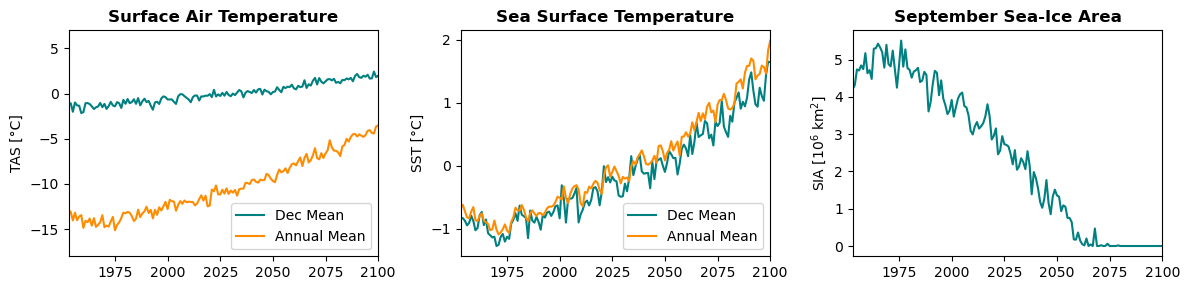

In [8]:
plot_raw_data(valid = False,save = False)

# Model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, fc_layers_num=[32,16,8], LSTMs=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = len(fc_layers_num)
        #print("Fully connected layers:",len(fc_layers_num)+1)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=LSTMs)
        
        self.fc_layers = nn.ModuleList()
        in_features = hidden_size * X_train.shape[1]
        for i in range(len(fc_layers_num)):
            out_features = fc_layers_num[i]
            self.fc_layers.append(nn.Linear(in_features, out_features))
            in_features = out_features  # Update the input size for the next layer

        self.output_layer = nn.Linear(in_features, output_size)
        self.nonlin = nn.ReLU()

    def forward(self, x):

        output, _ = self.lstm(x)
        output = output.flatten(start_dim=1)
        for fc_layer in self.fc_layers:
            output = torch.tanh(fc_layer(output))
        output = self.output_layer(output) 
        output = self.nonlin(output)
        
        return output

# Plotting Functions for time evolution and loss

In [12]:
def plot_res(model, title,ax, update_state=True):
    Var_name = {"sst":"SST","tas":"SAT","both":"SAT & SST",2:"2 Years",6:"6 Years",10:"10 Years",20:"20 Years"}
    Var_color = {"sst":"teal","tas":"darkorange","both":"plum",2:"teal",6:"darkorange",10:"plum",20:"firebrick"}
    
    if update_state:
        model.load_state_dict(best_state)

    with torch.no_grad():
        predicted_hist = model(X_train)
        #R = np.corrcoef(y_test,predicted_ssp.detach().numpy())
        #print("Training",criterion(predicted_hist,y_train).item())
        print("Training",np.corrcoef(y_train.detach().numpy()[:,0],predicted_hist.detach().numpy()[:,0])[1,0])
        predicted_ssp = model(X_test)
    
    #plt.figure(figsize=(20,5))
    #ax.axhline(y=1, c='dimgray', linestyle='--')    
    ax.axvline(x=2022, c='dimgray', linestyle='--')  
    ax.plot(hist,denorm_sia(y_train),c="black")
    ax.plot(hist,denorm_sia(predicted_hist),c=Var_color[var],label=Var_name[var])
    
    ax.plot(ssp,denorm_sia(y_test),c="black")
    ax.plot(ssp,denorm_sia(predicted_ssp),c=Var_color[var])
    #plt.plot(ssp,y_test,c="teal")
    #plt.plot(ssp,predicted_ssp,c="darkorange")
    ax.margins(x=0)
    ax.legend()
    #plt.show()

In [13]:
def plot_loss(Loss, Loss_v, best_epoch):
    print(f"Best epoch: {best_epoch}")#
    plt.plot(Loss)
    plt.plot(Loss_v)

# Training & Testing Functions

In [14]:
def training(hidden_size=100, learning_rate=0.0005, opti=torch.optim.Adam, criterion=torch.nn.MSELoss(), seed = True, num_epochs=1000, breaking=25,FCs=[],LSTMs=1):
    input_size = X_train.shape[-1]
    output_size = 1
    if seed: # Set seed for reproducibility
        manualSeed = 1234567#1234#123
        #print("Random Seed: ", manualSeed)
        random.seed(manualSeed)
        torch.manual_seed(manualSeed)
        torch.use_deterministic_algorithms(True)
        
    # Create the LSTM model
    model = LSTMModel(input_size, hidden_size, output_size,FCs,LSTMs)

    # Define the loss function and optimizer
    optimizer = opti(model.parameters(), lr=learning_rate)
    
    Loss, Loss_v = [], []
    
    for epoch in tqdm(range(num_epochs)):
        # Forward pass
        for batch_idx, (seq,labels) in enumerate(train_loader):
            output = model(seq)
            loss = criterion(output, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        Loss.append(loss.detach().numpy())

        with torch.no_grad():
            predicted = model(X_valid)
            loss_valid = criterion(predicted, y_valid)
        Loss_v.append(loss_valid.detach().numpy())

        if min(Loss_v) == Loss_v[epoch]:
            best_epoch = epoch
            best_state = deepcopy(model.state_dict())
        if (len(Loss_v) - np.where(Loss_v == min(Loss_v))[0][0] > breaking):
            print(f"Stopped the loop after {epoch} epochs")
            #print(f"  Validation Loss didn't improve for {breaking} epochs")
            break
    print("Best epoch:", best_epoch)
    return model, Loss, Loss_v, best_state, best_epoch

In [15]:
def testing(ax,plot = True):
    criterion=torch.nn.MSELoss()
    model.load_state_dict(best_state)

    with torch.no_grad():
        for _, batch in enumerate(test_loader):
            
            x_batch, y_batch = batch[0], batch[1]
            predicted_ssp = model(x_batch)
        R = np.corrcoef(y_test.detach().numpy()[:,0],predicted_ssp.detach().numpy()[:,0])[1,0]
        MSE = criterion(predicted_ssp,y_test).item()#y_batch
    print("Testing: R =",R)
    if plot:
        plot_res(model,"",ax)
        #plot_diff(model,"")
    return MSE

# Traning

## Individual Runs

In [36]:
var = "both"
train_loader, test_loader, X_valid, y_valid, X_train, y_train, X_test, y_test, hist, ssp = prep_data2(var,batch_size=8,w=10)

In [37]:
model, Loss, Loss_v, best_state, best_epoch = training(hidden_size=16, learning_rate=0.001, criterion=torch.nn.L1Loss(), num_epochs=3000,breaking=50,FCs = [],LSTMs=1)

  4%|▍         | 116/3000 [00:02<01:04, 44.79it/s]

Stopped the loop after 116 epochs
Best epoch: 66


Best epoch: 66


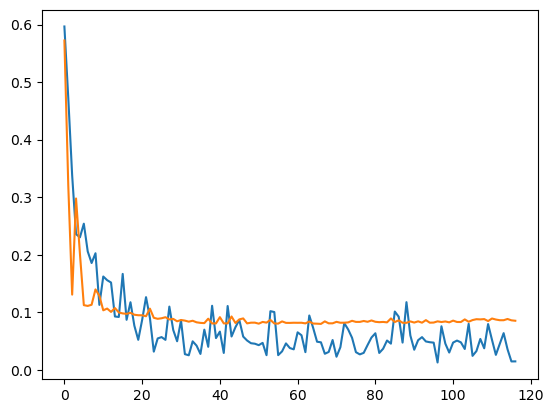

In [38]:
plot_loss(Loss, Loss_v, best_epoch)

Testing: R = 0.9661973559233272
Training 0.897379225336212


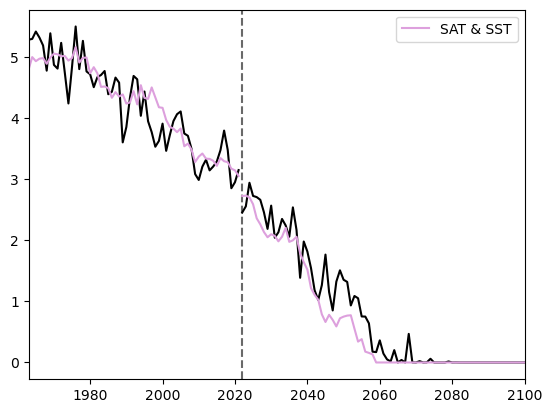

In [39]:
fig, ax = plt.subplots(1)
MSE = testing(ax) # tas

## Influence of window size

2


 10%|▉         | 298/3000 [00:08<01:18, 34.55it/s]


Stopped the loop after 298 epochs
Best epoch: 198
Testing: R = 0.9290278936015108
Training 0.8559854078015433

6


  9%|▊         | 259/3000 [00:06<01:09, 39.65it/s]


Stopped the loop after 259 epochs
Best epoch: 159
Testing: R = 0.9810277336025425
Training 0.8828957761647609

10


 16%|█▌        | 487/3000 [00:11<01:00, 41.31it/s]


Stopped the loop after 487 epochs
Best epoch: 387
Testing: R = 0.9769754520628042
Training 0.9256540303190017

20


 39%|███▉      | 1171/3000 [00:26<00:41, 44.35it/s]


Stopped the loop after 1171 epochs
Best epoch: 1071
Testing: R = 0.9708913185716961
Training 0.9986101903192317



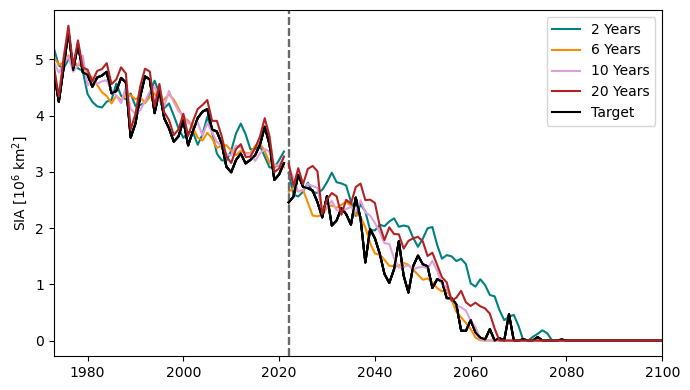

In [40]:
fig = plt.figure(figsize=(7,4),tight_layout=True)
ax = fig.subplots(1)
criterion=torch.nn.MSELoss()

windows = [2,6,10,20]

for i,w in enumerate(windows):
    print(w)
    train_loader, test_loader, X_valid, y_valid, X_train, y_train, X_test, y_test, hist, ssp = prep_data2("both",batch_size=8,w=w)
    model, Loss, Loss_v, best_state, best_epoch = training(hidden_size=32, learning_rate=0.0005, criterion=torch.nn.MSELoss(), num_epochs=3000,breaking=100,FCs = [],LSTMs=1)
    var = w
    MSE = testing(ax,w)
    print()
    
ax.plot(np.nan,np.nan,c="black",label="Target")  

ax.set_xlim(hist[0],2100)#
ax.legend()
ax.set_ylabel(r"SIA [10$^6$ km$^2$]")
plt.savefig("Barents-TS_Test.png",dpi=300)

# Hyper Parameter Tuning

In [41]:
Vars           = ["tas","sst","both"]

0.001_32_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:07<03:41, 13.10it/s]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/torch/nn/modules/module.py:1428: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_32_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:04<02:00, 24.08it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_32_Adam_MSELoss_[8]


  4%|▍         | 125/3000 [00:05<02:06, 22.66it/s]


Stopped the loop after 125 epochs
25
torch.Size([79, 1]) torch.Size([79, 1])
0.7955744521739165

0.001_32_Adam_L1Loss_[8]


  4%|▍         | 125/3000 [00:05<02:07, 22.59it/s]


Stopped the loop after 125 epochs
25
torch.Size([79, 1]) torch.Size([79, 1])
0.7997904889711163

0.001_32_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:04<02:12, 21.84it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6350411374284399

0.001_32_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:04<02:13, 21.73it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6350411374284399

0.0005_32_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:04<01:59, 24.25it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_32_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:04<02:00, 24.16it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_32_Adam_MSELoss_[8]


  5%|▍         | 141/3000 [00:06<02:07, 22.48it/s]


Stopped the loop after 141 epochs
41
torch.Size([79, 1]) torch.Size([79, 1])
0.7930338022966588

0.0005_32_Adam_L1Loss_[8]


  5%|▌         | 151/3000 [00:06<02:06, 22.53it/s]


Stopped the loop after 151 epochs
51
torch.Size([79, 1]) torch.Size([79, 1])
0.8017444787140666

0.0005_32_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:04<02:13, 21.73it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6350411374284399

0.0005_32_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:04<02:13, 21.79it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6350411374284399

0.0001_32_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:04<01:58, 24.43it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_32_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:04<01:59, 24.26it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_32_Adam_MSELoss_[8]


 10%|█         | 307/3000 [00:13<01:59, 22.55it/s]


Stopped the loop after 307 epochs
207
torch.Size([79, 1]) torch.Size([79, 1])
0.790479064126214

0.0001_32_Adam_L1Loss_[8]


 10%|█         | 307/3000 [00:13<01:58, 22.63it/s]


Stopped the loop after 307 epochs
207
torch.Size([79, 1]) torch.Size([79, 1])
0.7990602094418319

0.0001_32_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:04<02:11, 22.02it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6350411374284399

0.0001_32_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:04<02:12, 21.81it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6350411374284399

0.001_64_Adam_MSELoss_[]


  4%|▍         | 129/3000 [00:05<02:04, 23.07it/s]


Stopped the loop after 129 epochs
29
torch.Size([79, 1]) torch.Size([79, 1])
0.7542136487388527

0.001_64_Adam_L1Loss_[]


  6%|▌         | 172/3000 [00:07<02:02, 23.06it/s]


Stopped the loop after 172 epochs
72
torch.Size([79, 1]) torch.Size([79, 1])
0.8339335025522837

0.001_64_Adam_MSELoss_[8]


  4%|▍         | 124/3000 [00:05<02:14, 21.43it/s]


Stopped the loop after 124 epochs
24
torch.Size([79, 1]) torch.Size([79, 1])
0.7497391236803598

0.001_64_Adam_L1Loss_[8]


  5%|▌         | 159/3000 [00:07<02:13, 21.22it/s]


Stopped the loop after 159 epochs
59
torch.Size([79, 1]) torch.Size([79, 1])
0.814294592971793

0.001_64_Adam_MSELoss_[16, 8]


  4%|▍         | 122/3000 [00:05<02:17, 20.86it/s]


Stopped the loop after 122 epochs
22
torch.Size([79, 1]) torch.Size([79, 1])
0.8063939589529036

0.001_64_Adam_L1Loss_[16, 8]


  4%|▍         | 132/3000 [00:06<02:18, 20.78it/s]


Stopped the loop after 132 epochs
32
torch.Size([79, 1]) torch.Size([79, 1])
0.8182749456955637

0.0005_64_Adam_MSELoss_[]


  6%|▌         | 166/3000 [00:07<02:01, 23.26it/s]


Stopped the loop after 166 epochs
66
torch.Size([79, 1]) torch.Size([79, 1])
0.7714458090335764

0.0005_64_Adam_L1Loss_[]


  6%|▋         | 192/3000 [00:08<02:02, 22.97it/s]


Stopped the loop after 192 epochs
92
torch.Size([79, 1]) torch.Size([79, 1])
0.809005748527577

0.0005_64_Adam_MSELoss_[8]


  5%|▍         | 143/3000 [00:06<02:13, 21.42it/s]


Stopped the loop after 143 epochs
43
torch.Size([79, 1]) torch.Size([79, 1])
0.7448556438328225

0.0005_64_Adam_L1Loss_[8]


  6%|▋         | 195/3000 [00:09<02:11, 21.34it/s]


Stopped the loop after 195 epochs
95
torch.Size([79, 1]) torch.Size([79, 1])
0.8181746516052208

0.0005_64_Adam_MSELoss_[16, 8]


  5%|▍         | 140/3000 [00:06<02:17, 20.82it/s]


Stopped the loop after 140 epochs
40
torch.Size([79, 1]) torch.Size([79, 1])
0.8072839713770862

0.0005_64_Adam_L1Loss_[16, 8]


  5%|▍         | 145/3000 [00:06<02:16, 20.93it/s]


Stopped the loop after 145 epochs
45
torch.Size([79, 1]) torch.Size([79, 1])
0.8168689615292881

0.0001_64_Adam_MSELoss_[]


 12%|█▎        | 375/3000 [00:16<01:52, 23.30it/s]


Stopped the loop after 375 epochs
275
torch.Size([79, 1]) torch.Size([79, 1])
0.75818181414707

0.0001_64_Adam_L1Loss_[]


 18%|█▊        | 543/3000 [00:22<01:41, 24.28it/s]


Stopped the loop after 543 epochs
443
torch.Size([79, 1]) torch.Size([79, 1])
0.822219016255739

0.0001_64_Adam_MSELoss_[8]


 10%|█         | 305/3000 [00:13<01:58, 22.81it/s]


Stopped the loop after 305 epochs
205
torch.Size([79, 1]) torch.Size([79, 1])
0.7467984367762565

0.0001_64_Adam_L1Loss_[8]


 13%|█▎        | 395/3000 [00:17<01:54, 22.84it/s]


Stopped the loop after 395 epochs
295
torch.Size([79, 1]) torch.Size([79, 1])
0.8035412846305001

0.0001_64_Adam_MSELoss_[16, 8]


  8%|▊         | 239/3000 [00:10<02:04, 22.12it/s]


Stopped the loop after 239 epochs
139
torch.Size([79, 1]) torch.Size([79, 1])
0.805249818652496

0.0001_64_Adam_L1Loss_[16, 8]


 11%|█         | 329/3000 [00:14<02:00, 22.09it/s]


Stopped the loop after 329 epochs
229
torch.Size([79, 1]) torch.Size([79, 1])
0.8150351492924146

0.001_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:42, 28.29it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8254080155806242

0.001_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:42, 28.30it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8254080155806242

0.001_96_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:49, 26.39it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:50, 26.36it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_MSELoss_[16, 8]


  4%|▍         | 119/3000 [00:04<01:48, 26.59it/s]


Stopped the loop after 119 epochs
19
torch.Size([79, 1]) torch.Size([79, 1])
0.8116943087795254

0.001_96_Adam_L1Loss_[16, 8]


  4%|▍         | 123/3000 [00:04<01:49, 26.34it/s]


Stopped the loop after 123 epochs
23
torch.Size([79, 1]) torch.Size([79, 1])
0.8148284779557387

0.0005_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:42, 28.41it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8254080155806242

0.0005_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:41, 28.47it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8254080155806242

0.0005_96_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:48, 26.67it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:49, 26.42it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_MSELoss_[16, 8]


  4%|▍         | 128/3000 [00:04<01:47, 26.61it/s]


Stopped the loop after 128 epochs
28
torch.Size([79, 1]) torch.Size([79, 1])
0.8132593719503661

0.0005_96_Adam_L1Loss_[16, 8]


  4%|▍         | 134/3000 [00:05<01:48, 26.46it/s]


Stopped the loop after 134 epochs
34
torch.Size([79, 1]) torch.Size([79, 1])
0.8176580173339056

0.0001_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:41, 28.64it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8254080155806242

0.0001_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:42, 28.36it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8254080155806242

0.0001_96_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:49, 26.48it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:50, 26.36it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_MSELoss_[16, 8]


  9%|▊         | 257/3000 [00:09<01:43, 26.54it/s]


Stopped the loop after 257 epochs
157
torch.Size([79, 1]) torch.Size([79, 1])
0.8176692956461552

0.0001_96_Adam_L1Loss_[16, 8]


  8%|▊         | 229/3000 [00:08<01:44, 26.49it/s]


Stopped the loop after 229 epochs
129
torch.Size([79, 1]) torch.Size([79, 1])
0.8190697656207314

------------------------- 0.001_64_Adam_L1Loss_[] -------------------------
0.001_32_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:23, 34.72it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_32_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:24, 34.38it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_32_Adam_MSELoss_[8]


  4%|▍         | 121/3000 [00:03<01:28, 32.61it/s]


Stopped the loop after 121 epochs
21
torch.Size([79, 1]) torch.Size([79, 1])
0.8057887680320048

0.001_32_Adam_L1Loss_[8]


  7%|▋         | 205/3000 [00:06<01:26, 32.47it/s]


Stopped the loop after 205 epochs
105
torch.Size([79, 1]) torch.Size([79, 1])
0.7076747970585247

0.001_32_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:35, 30.50it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6354888851782088

0.001_32_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:35, 30.29it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6354888851782088

0.0005_32_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:23, 34.53it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_32_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:25, 34.08it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_32_Adam_MSELoss_[8]


  4%|▍         | 135/3000 [00:04<01:27, 32.59it/s]


Stopped the loop after 135 epochs
35
torch.Size([79, 1]) torch.Size([79, 1])
0.8018089806461141

0.0005_32_Adam_L1Loss_[8]


 13%|█▎        | 376/3000 [00:11<01:21, 32.36it/s]


Stopped the loop after 376 epochs
276
torch.Size([79, 1]) torch.Size([79, 1])
-0.51476313720704

0.0005_32_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:34, 30.66it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6354888851782088

0.0005_32_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:35, 30.43it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6354888851782088

0.0001_32_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:23, 34.57it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_32_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:24, 34.26it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_32_Adam_MSELoss_[8]


 13%|█▎        | 389/3000 [00:11<01:20, 32.56it/s]


Stopped the loop after 389 epochs
289
torch.Size([79, 1]) torch.Size([79, 1])
0.8147918467151528

0.0001_32_Adam_L1Loss_[8]


 24%|██▍       | 731/3000 [00:18<00:56, 39.81it/s]


Stopped the loop after 731 epochs
631
torch.Size([79, 1]) torch.Size([79, 1])
0.8208030157749112

0.0001_32_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:02<01:15, 38.40it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6354888851782088

0.0001_32_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:02<01:11, 40.56it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.6354888851782088

0.001_64_Adam_MSELoss_[]


  5%|▍         | 145/3000 [00:03<01:04, 44.19it/s]


Stopped the loop after 145 epochs
45
torch.Size([79, 1]) torch.Size([79, 1])
0.7659869576182649

0.001_64_Adam_L1Loss_[]


  6%|▋         | 195/3000 [00:04<01:05, 42.99it/s]


Stopped the loop after 195 epochs
95
torch.Size([79, 1]) torch.Size([79, 1])
0.8471368417569108

0.001_64_Adam_MSELoss_[8]


  5%|▍         | 143/3000 [00:03<01:10, 40.30it/s]


Stopped the loop after 143 epochs
43
torch.Size([79, 1]) torch.Size([79, 1])
0.7602879765528241

0.001_64_Adam_L1Loss_[8]


  7%|▋         | 196/3000 [00:06<01:31, 30.76it/s]


Stopped the loop after 196 epochs
96
torch.Size([79, 1]) torch.Size([79, 1])
0.8500754065099051

0.001_64_Adam_MSELoss_[16, 8]


  4%|▍         | 121/3000 [00:04<01:37, 29.66it/s]


Stopped the loop after 121 epochs
21
torch.Size([79, 1]) torch.Size([79, 1])
0.8152980597117718

0.001_64_Adam_L1Loss_[16, 8]


  7%|▋         | 196/3000 [00:06<01:34, 29.55it/s]


Stopped the loop after 196 epochs
96
torch.Size([79, 1]) torch.Size([79, 1])
-0.270085716044287

0.0005_64_Adam_MSELoss_[]


  6%|▋         | 194/3000 [00:05<01:24, 33.26it/s]


Stopped the loop after 194 epochs
94
torch.Size([79, 1]) torch.Size([79, 1])
0.778825154092812

0.0005_64_Adam_L1Loss_[]


  6%|▋         | 193/3000 [00:05<01:24, 33.09it/s]


Stopped the loop after 193 epochs
93
torch.Size([79, 1]) torch.Size([79, 1])
0.7920970414720097

0.0005_64_Adam_MSELoss_[8]


  6%|▌         | 174/3000 [00:05<01:31, 30.87it/s]


Stopped the loop after 174 epochs
74
torch.Size([79, 1]) torch.Size([79, 1])
0.7613389839372514

0.0005_64_Adam_L1Loss_[8]


  5%|▌         | 156/3000 [00:05<01:32, 30.73it/s]


Stopped the loop after 156 epochs
56
torch.Size([79, 1]) torch.Size([79, 1])
0.7651844036300087

0.0005_64_Adam_MSELoss_[16, 8]


  5%|▍         | 143/3000 [00:04<01:37, 29.33it/s]


Stopped the loop after 143 epochs
43
torch.Size([79, 1]) torch.Size([79, 1])
0.8193342610750823

0.0005_64_Adam_L1Loss_[16, 8]


  9%|▉         | 266/3000 [00:09<01:32, 29.49it/s]


Stopped the loop after 266 epochs
166
torch.Size([79, 1]) torch.Size([79, 1])
-0.10003733359819152

0.0001_64_Adam_MSELoss_[]


 13%|█▎        | 403/3000 [00:12<01:18, 33.16it/s]


Stopped the loop after 403 epochs
303
torch.Size([79, 1]) torch.Size([79, 1])
0.757991683041106

0.0001_64_Adam_L1Loss_[]


 15%|█▌        | 450/3000 [00:13<01:17, 32.90it/s]


Stopped the loop after 450 epochs
350
torch.Size([79, 1]) torch.Size([79, 1])
0.7711246796374017

0.0001_64_Adam_MSELoss_[8]


 12%|█▏        | 362/3000 [00:11<01:26, 30.66it/s]


Stopped the loop after 362 epochs
262
torch.Size([79, 1]) torch.Size([79, 1])
0.7391780221511917

0.0001_64_Adam_L1Loss_[8]


 15%|█▍        | 436/3000 [00:14<01:23, 30.59it/s]


Stopped the loop after 436 epochs
336
torch.Size([79, 1]) torch.Size([79, 1])
0.7869784149374955

0.0001_64_Adam_MSELoss_[16, 8]


 10%|█         | 311/3000 [00:10<01:31, 29.55it/s]


Stopped the loop after 311 epochs
211
torch.Size([79, 1]) torch.Size([79, 1])
0.8214864996463239

0.0001_64_Adam_L1Loss_[16, 8]


 13%|█▎        | 394/3000 [00:13<01:28, 29.31it/s]


Stopped the loop after 394 epochs
294
torch.Size([79, 1]) torch.Size([79, 1])
0.8260920554120749

0.001_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:39, 29.04it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8147227160509292

0.001_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:40, 28.72it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8147227160509292

0.001_96_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:47, 27.04it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:30, 32.07it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_MSELoss_[16, 8]


  4%|▍         | 123/3000 [00:03<01:27, 32.96it/s]


Stopped the loop after 123 epochs
23
torch.Size([79, 1]) torch.Size([79, 1])
0.825571331488381

0.001_96_Adam_L1Loss_[16, 8]


  5%|▌         | 160/3000 [00:04<01:27, 32.46it/s]


Stopped the loop after 160 epochs
60
torch.Size([79, 1]) torch.Size([79, 1])
0.8355080888005568

0.0005_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:23, 34.80it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8147227160509292

0.0005_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:23, 34.66it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8147227160509292

0.0005_96_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:41, 28.71it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:02<01:26, 33.50it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_MSELoss_[16, 8]


  5%|▍         | 136/3000 [00:03<01:18, 36.50it/s]


Stopped the loop after 136 epochs
36
torch.Size([79, 1]) torch.Size([79, 1])
0.829880895564623

0.0005_96_Adam_L1Loss_[16, 8]


  4%|▍         | 133/3000 [00:03<01:20, 35.82it/s]


Stopped the loop after 133 epochs
33
torch.Size([79, 1]) torch.Size([79, 1])
0.8293126290298014

0.0001_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:14, 38.90it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8147227160509292

0.0001_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:13, 39.36it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8147227160509292

0.0001_96_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:02<01:19, 36.38it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:02<01:20, 36.13it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_MSELoss_[16, 8]


  8%|▊         | 250/3000 [00:06<01:15, 36.19it/s]


Stopped the loop after 250 epochs
150
torch.Size([79, 1]) torch.Size([79, 1])
0.8308647821459869

0.0001_96_Adam_L1Loss_[16, 8]


  8%|▊         | 246/3000 [00:06<01:16, 36.09it/s]


Stopped the loop after 246 epochs
146
torch.Size([79, 1]) torch.Size([79, 1])
0.8305592027850103

------------------------- 0.001_64_Adam_L1Loss_[] -------------------------
0.001_32_Adam_MSELoss_[]


  5%|▍         | 145/3000 [00:03<01:02, 45.37it/s]


Stopped the loop after 145 epochs
45
torch.Size([79, 1]) torch.Size([79, 1])
0.7432286055320497

0.001_32_Adam_L1Loss_[]


  5%|▍         | 145/3000 [00:03<01:02, 45.58it/s]


Stopped the loop after 145 epochs
45
torch.Size([79, 1]) torch.Size([79, 1])
0.7830562645254887

0.001_32_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:02<01:09, 41.47it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_32_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:02<01:11, 40.38it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_32_Adam_MSELoss_[16, 8]


  4%|▍         | 128/3000 [00:03<01:10, 40.80it/s]


Stopped the loop after 128 epochs
28
torch.Size([79, 1]) torch.Size([79, 1])
0.770951597992739

0.001_32_Adam_L1Loss_[16, 8]


  5%|▍         | 139/3000 [00:03<01:10, 40.48it/s]


Stopped the loop after 139 epochs
39
torch.Size([79, 1]) torch.Size([79, 1])
0.8140726065234414

0.0005_32_Adam_MSELoss_[]


  6%|▋         | 194/3000 [00:04<01:01, 45.60it/s]


Stopped the loop after 194 epochs
94
torch.Size([79, 1]) torch.Size([79, 1])
0.76001017054399

0.0005_32_Adam_L1Loss_[]


  7%|▋         | 220/3000 [00:04<01:00, 45.90it/s]


Stopped the loop after 220 epochs
120
torch.Size([79, 1]) torch.Size([79, 1])
0.8085883766874743

0.0005_32_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:02<01:11, 40.75it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_32_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:02<01:10, 41.18it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_32_Adam_MSELoss_[16, 8]


  5%|▌         | 155/3000 [00:03<01:10, 40.48it/s]


Stopped the loop after 155 epochs
55
torch.Size([79, 1]) torch.Size([79, 1])
0.7782543487390032

0.0005_32_Adam_L1Loss_[16, 8]


  5%|▌         | 160/3000 [00:04<01:19, 35.90it/s]


Stopped the loop after 160 epochs
60
torch.Size([79, 1]) torch.Size([79, 1])
0.7996144954858274

0.0001_32_Adam_MSELoss_[]


 16%|█▋        | 492/3000 [00:10<00:55, 44.85it/s]


Stopped the loop after 492 epochs
392
torch.Size([79, 1]) torch.Size([79, 1])
0.7689160591092489

0.0001_32_Adam_L1Loss_[]


 23%|██▎       | 698/3000 [00:16<00:55, 41.57it/s]


Stopped the loop after 698 epochs
598
torch.Size([79, 1]) torch.Size([79, 1])
0.8279632006063287

0.0001_32_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:02<01:22, 35.26it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_32_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:02<01:21, 35.43it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_32_Adam_MSELoss_[16, 8]


 11%|█▏        | 344/3000 [00:09<01:15, 35.01it/s]


Stopped the loop after 344 epochs
244
torch.Size([79, 1]) torch.Size([79, 1])
0.7791191731186751

0.0001_32_Adam_L1Loss_[16, 8]


 12%|█▏        | 350/3000 [00:10<01:16, 34.43it/s]


Stopped the loop after 350 epochs
250
torch.Size([79, 1]) torch.Size([79, 1])
0.7944636791936841

0.001_64_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:21, 35.79it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8088980011583292

0.001_64_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:20, 35.92it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8088980011583292

0.001_64_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:27, 33.31it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8163062156302325

0.001_64_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:27, 33.31it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8163062156302325

0.001_64_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:30, 32.01it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_64_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:31, 31.74it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_64_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:20, 36.14it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8088980011583292

0.0005_64_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:21, 35.65it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8088980011583292

0.0005_64_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:02<01:26, 33.60it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8163062156302325

0.0005_64_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:27, 33.12it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8163062156302325

0.0005_64_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:29, 32.23it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_64_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:31, 31.84it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_64_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:02<01:20, 35.85it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8088980011583292

0.0001_64_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:02<01:20, 36.20it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8088980011583292

0.0001_64_Adam_MSELoss_[8]


  3%|▎         | 100/3000 [00:03<01:27, 33.23it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8163062156302325

0.0001_64_Adam_L1Loss_[8]


  3%|▎         | 100/3000 [00:03<01:27, 33.27it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
-0.8163062156302325

0.0001_64_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:30, 31.97it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_64_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:31, 31.82it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:31, 31.82it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:31, 31.66it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_MSELoss_[8]


  4%|▍         | 119/3000 [00:03<01:34, 30.62it/s]


Stopped the loop after 119 epochs
19
torch.Size([79, 1]) torch.Size([79, 1])
0.8217058926059599

0.001_96_Adam_L1Loss_[8]


  4%|▍         | 118/3000 [00:03<01:34, 30.41it/s]


Stopped the loop after 118 epochs
18
torch.Size([79, 1]) torch.Size([79, 1])
0.8242690153522522

0.001_96_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:41, 28.53it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.001_96_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:42, 28.29it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:30, 32.04it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:32, 31.35it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_MSELoss_[8]


  4%|▍         | 128/3000 [00:04<01:34, 30.37it/s]


Stopped the loop after 128 epochs
28
torch.Size([79, 1]) torch.Size([79, 1])
0.8226956893701314

0.0005_96_Adam_L1Loss_[8]


  5%|▍         | 140/3000 [00:04<01:34, 30.34it/s]


Stopped the loop after 140 epochs
40
torch.Size([79, 1]) torch.Size([79, 1])
0.8238430357381803

0.0005_96_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:41, 28.49it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0005_96_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:41, 28.54it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_MSELoss_[]


  3%|▎         | 100/3000 [00:03<01:31, 31.81it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_L1Loss_[]


  3%|▎         | 100/3000 [00:03<01:32, 31.47it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_MSELoss_[8]


  6%|▋         | 194/3000 [00:06<01:32, 30.48it/s]


Stopped the loop after 194 epochs
94
torch.Size([79, 1]) torch.Size([79, 1])
0.8213689293835009

0.0001_96_Adam_L1Loss_[8]


  9%|▉         | 283/3000 [00:09<01:30, 30.06it/s]


Stopped the loop after 283 epochs
183
torch.Size([79, 1]) torch.Size([79, 1])
0.8317990883251303

0.0001_96_Adam_MSELoss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:42, 28.22it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

0.0001_96_Adam_L1Loss_[16, 8]


  3%|▎         | 100/3000 [00:03<01:42, 28.38it/s]


Stopped the loop after 100 epochs
100
torch.Size([79, 1]) torch.Size([79, 1])
nan

------------------------- 0.0005_96_Adam_MSELoss_[8] -------------------------


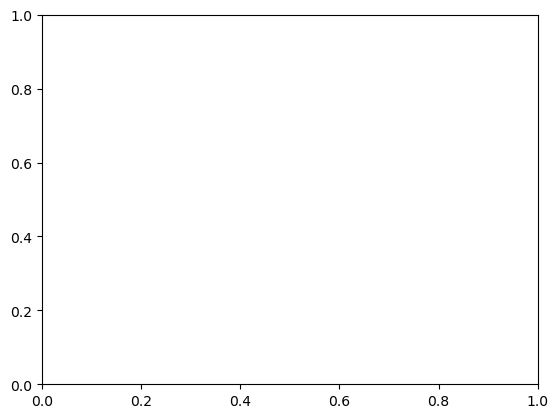

In [15]:
import shutil
inpath = "./barents_states/" # Barents Sea
inpath = "./model_states/"   # Arctic

Learning_rates = [0.001,0.0005,0.0001]
Layers         = [32,64,96]
Optimizers     = [torch.optim.SGD, torch.optim.Adam]
Criterions     = [torch.nn.MSELoss(),torch.nn.L1Loss()]
Vars           = ["tas","sst","both"]
FCS            = [[],[8],[16,8]]
fig,ax = plt.subplots(1)
Experiments = {}

for var in Vars:
    train_loader, test_loader, X_valid, y_valid, X_train, y_train, X_test, y_test, hist, ssp = prep_data2(var,batch_size=8,w=6)
    
    Experiments[var] = {}
    for opt in Optimizers[1:]:
        for layers in Layers[:]:
            for LR in Learning_rates[:]:
                for FCs in FCS[:]:
                    for criterion in Criterions[:]:
                        setup = str(LR) +"_"+ str(layers) +"_"+str(opt).split("'")[1].split(".")[-1] +"_"+ str(criterion)[:-2]+"_"+ str(FCs)
                        print(setup)
                        model, Loss, Loss_v, best_state, best_epoch = training(hidden_size=layers, learning_rate=LR, opti=opt, criterion=criterion, num_epochs=3000,breaking=100,FCs=FCs,LSTMs=1)
                        MSE = testing(ax,plot=False)

                        torch.save(model.state_dict(best_state), inpath +setup+".pt")
                        Experiments[var][MSE] = setup
                        print()
    Keys = list(Experiments[var].keys())
    best_setup = Experiments[var][min(Keys)]
    print(f"------------------------- {best_setup} -------------------------")
    shutil.copyfile(inpath +best_setup+".pt", inpath +var+"_"+best_setup+".pt")

## Overview of the performance of the setups

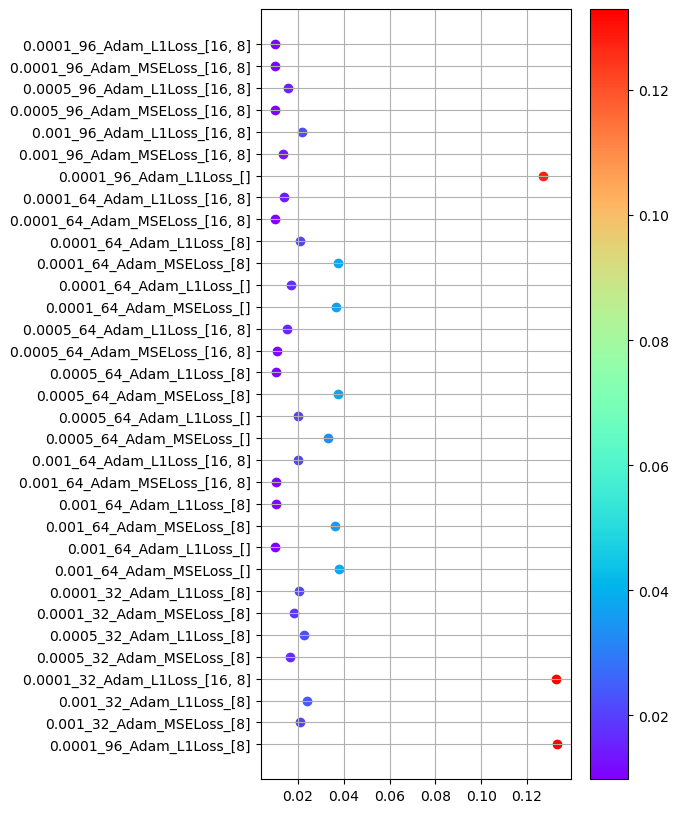

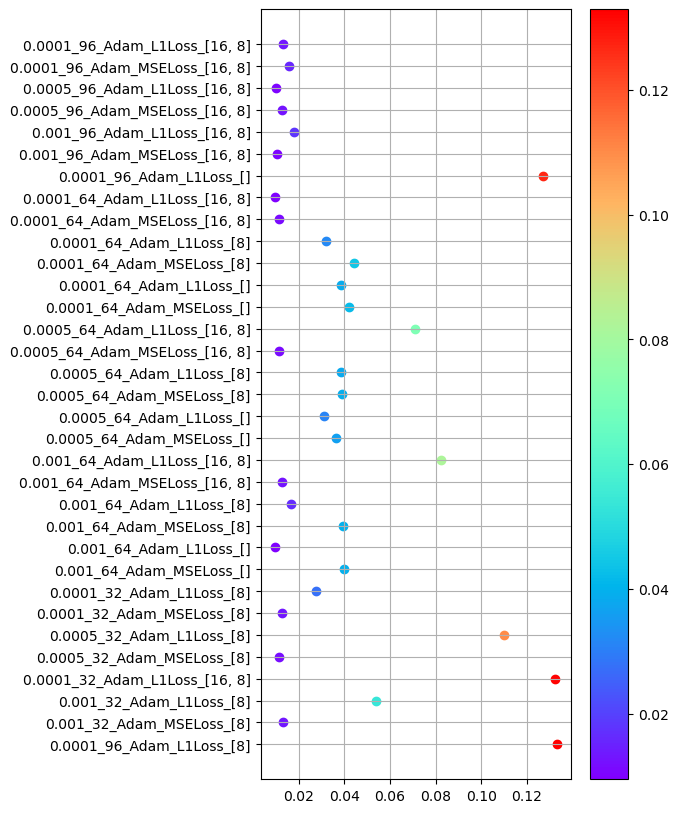

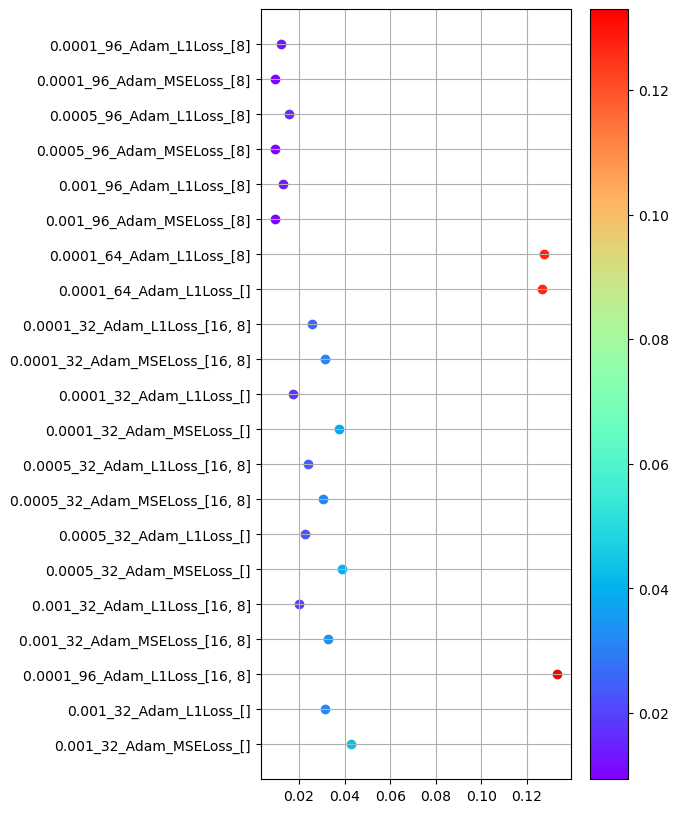

In [16]:
for var in Vars:
    plt.figure(figsize=(5,10))
    for experiment in list(Experiments[var].keys()):
        plt.scatter(experiment,Experiments[var][experiment],c=experiment,cmap="rainbow",vmin=min(list(Experiments[var].keys())),vmax=max(list(Experiments[var].keys())))
    plt.colorbar()
    plt.grid()
    #plt.xlim(0.005,0.0125)

# Linear Model

(148,) (148,)


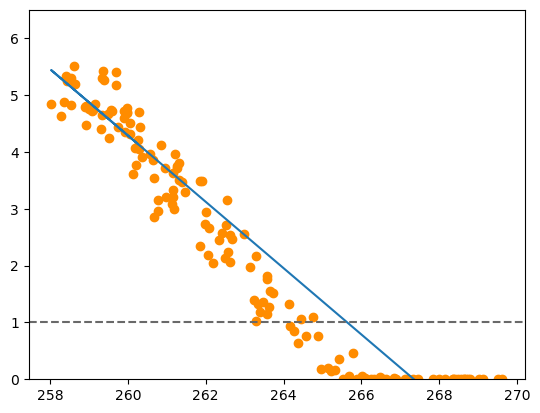

In [42]:
from sklearn.linear_model import LinearRegression
x = r1["tas_mean"]
print(x.shape,sia.shape)
reg = LinearRegression().fit(x[:cut].reshape(-1, 1), sia[:cut])
y_hat = reg.predict(x.reshape(-1, 1))

plt.scatter(x, sia,c="darkorange")
plt.plot(x,y_hat)
plt.ylim(0,6.5)
plt.axhline(y=1, c='dimgray', linestyle='--')

# Plot best runs of LSTM with Target and Linear Model

## Barents Sea

tas 0.001_64_Adam_L1Loss_[] 0.009786802344024181
/home/u/u301557/DL_Project/barents_states/tas_0.001_64_Adam_L1Loss_[].pt
6 64 []
Training: 0.012100629
Testing: 0.009786802
sst 0.001_64_Adam_L1Loss_[] 0.009473027661442757
/home/u/u301557/DL_Project/barents_states/sst_0.001_64_Adam_L1Loss_[].pt
6 64 []
Training: 0.011488934
Testing: 0.009473028
both 0.0005_96_Adam_MSELoss_[8] 0.009360167197883129
/home/u/u301557/DL_Project/barents_states/both_0.0005_96_Adam_MSELoss_[8].pt
6 96 [8]
Training: 0.011999853
Testing: 0.009360167
Linear 0.07529942691326141


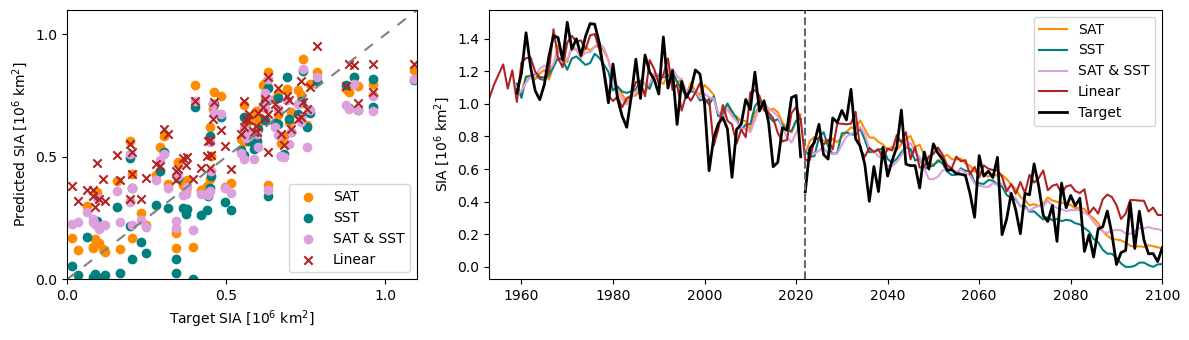

In [30]:
Var_name = {"sst":"SST","tas":"SAT","both":"SAT & SST"}
fc_dict = {"[]":[],"[8]":[8],"[16, 8]":[16,8]}
colors = ["darkorange","teal","plum"]

fig1 = plt.figure(figsize=(12,3.5),tight_layout=True)
ax1,ax2 = fig1.subplots(1,2, gridspec_kw={'width_ratios': [1.3, 2.5]})


for i,var in enumerate(Vars):
    train_loader, test_loader, X_valid, y_valid, X_train, y_train, X_test, y_test, hist, ssp = prep_data2(var,batch_size=8,w=6)
    input_size = X_train.shape[-1]
    Keys = list(Experiments[var].keys())
    best_setup = Experiments[var][min(Keys)]
    experiment = min(Keys)
    print(var,best_setup,experiment)
    file = glob.glob(f"/home/u/u301557/DL_Project/barents_states/{var}*")[0]
    print(file)

    name = file.split("/")[-1]
    layers = int( name.split("_")[2])
    FCs = name.split("_")[-1].split(".")[0]
    FCs = fc_dict[FCs]
    
    print(input_size,layers,FCs)
    model2 = LSTMModel(input_size, layers, 1,FCs)
    model2.load_state_dict(torch.load(file))
    
    with torch.no_grad():
            predicted_hist = model2(X_train)
            MSE = sklearn.metrics.mean_squared_error(y_train,predicted_hist)
            R = np.corrcoef(y_train.detach().numpy()[:,0],predicted_hist.detach().numpy()[:,0])[1,0]
            print("Training:",MSE)
            predicted_ssp = model2(X_test)
            MSE = sklearn.metrics.mean_squared_error(y_test,predicted_ssp)
            R = np.corrcoef(y_test.detach().numpy()[:,0],predicted_ssp.detach().numpy()[:,0])[1,0]
            print("Testing:",MSE)
    ax2.plot(hist,denorm_sia(predicted_hist),c=colors[i],label = Var_name[var])
    ax2.plot(ssp,denorm_sia(predicted_ssp),c=colors[i])
    #MSE = sklearn.metrics.mean_squared_error(y_test,predicted_ssp)
    ax1.scatter(denorm_sia(y_test),denorm_sia(predicted_ssp),c=colors[i],label = f"{Var_name[var]}")#(MSE = {(MSE*1000):.2f}"+r"$\times10^{-3}$)
    
MSE = sklearn.metrics.mean_squared_error(y_test,y_hat[69:])    
ax1.scatter(denorm_sia(y_test),y_hat[69:],c="firebrick",label = f"Linear",marker="x")# (MSE = {(MSE):.2f})

ax1.set_ylim(0,1.1)
ax1.set_xlim(0,1.1)   
ax1.axline((0, 0), slope=1, color="gray", linestyle=(0, (5, 5)))
ax1.legend(loc=4)
ax1.set_xlabel("Target SIA [10$^6$ km$^2$]")
ax1.set_ylabel("Predicted SIA [10$^6$ km$^2$]")
ax1.set_xticks([0,0.5,1])
ax1.set_yticks([0,0.5,1])

ax2.plot(range(1850+start,2101),y_hat,c="firebrick",label = f"Linear")
print("Linear",sklearn.metrics.mean_squared_error(y_test,torch.tensor(y_hat[69:])).item())
ax2.plot(hist,denorm_sia(y_train),c="black",linewidth=2.0,label="Target")
ax2.plot(ssp,denorm_sia(y_test),c="black",linewidth=2.0)        
ax2.axvline(x=2022, c='dimgray', linestyle='--')  
ax2.margins(x=0)
#ax2.set_ylim(-0.1,1.2)
#ax2.set_xlim(2022,2090)
ax2.legend()
#ax2.set_ylim(-0.5,5.5)
ax2.set_ylabel(r"SIA [10$^6$ km$^2$]")
plt.savefig("Barents-TS-SC.png",dpi=300)
#fig1.savefig("Arctic-scatter.png")
#fig2.savefig("Arctic-scatter.png")

plt.show()

# Arctic

tas 0.0001_64_Adam_MSELoss_[8] 0.001261877710931003
/home/u/u301557/DL_Project/model_states/tas_0.0001_64_Adam_MSELoss_[8].pt
6 64 [8]
Training: 0.003693376
Testing: 0.0012618777
sst 0.0005_64_Adam_L1Loss_[] 0.0020016301423311234
/home/u/u301557/DL_Project/model_states/sst_0.0005_64_Adam_L1Loss_[].pt
6 64 []
Training: 0.005436184
Testing: 0.0020016304
both 0.0001_32_Adam_L1Loss_[] 0.001189064234495163
/home/u/u301557/DL_Project/model_states/both_0.0001_32_Adam_L1Loss_[].pt
6 32 []
Training: 0.0039627943
Testing: 0.0011890642


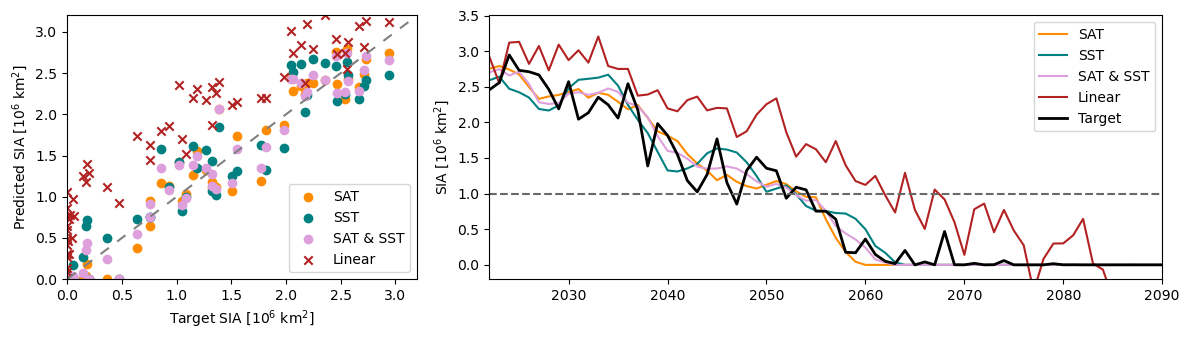

In [54]:
Var_name = {"sst":"SST","tas":"SAT","both":"SAT & SST"}
import sklearn
fig1 = plt.figure(figsize=(12,3.5),tight_layout=True)
#ax1 = fig1.subplots(1)

#fig2 = plt.figure(figsize=(10,5))
#ax2 = fig2.subplots(1)

ax1,ax2 = fig1.subplots(1,2, gridspec_kw={'width_ratios': [1.3, 2.5]})

#fig1.suptitle("Arctic Testing Data",fontweight="bold")

colors = ["darkorange","teal","plum"]

for i,var in enumerate(Vars):
    train_loader, test_loader, X_valid, y_valid, X_train, y_train, X_test, y_test, hist, ssp = prep_data2(var,batch_size=8,w=6)
    input_size = X_train.shape[-1]
    Keys = list(Experiments[var].keys())
    best_setup = Experiments[var][min(Keys)]
    experiment = min(Keys)
    print(var,best_setup,experiment)
    file = glob.glob(f"/home/u/u301557/DL_Project/model_states/{var}*")[0]
    print(file)
    #layers = int(Experiments[var][experiment].split("_")[1])
    name = file.split("/")[-1]
    layers = int( name.split("_")[2])
    FCs = name.split("_")[-1].split(".")[0]
    FCs = fc_dict[FCs]
    
    print(input_size,layers,FCs)
    model2 = LSTMModel(input_size, layers, 1,FCs)
    model2.load_state_dict(torch.load(file))
    
    with torch.no_grad():
            predicted_hist = model2(X_train)
            R = np.corrcoef(y_train.detach().numpy()[:,0],predicted_hist.detach().numpy()[:,0])[1,0]
            MSE = sklearn.metrics.mean_squared_error(y_train,predicted_hist)
            print("Training:",MSE)
            predicted_ssp = model2(X_test)
            R = np.corrcoef(y_test.detach().numpy()[:,0],predicted_ssp.detach().numpy()[:,0])[1,0]
            MSE = sklearn.metrics.mean_squared_error(y_test,predicted_ssp)
            print("Testing:",MSE)
    ax2.plot(hist,denorm_sia(predicted_hist),c=colors[i],label = Var_name[var])
    ax2.plot(ssp,denorm_sia(predicted_ssp),c=colors[i])
    #MSE = sklearn.metrics.mean_squared_error(y_test,predicted_ssp)
    ax1.scatter(denorm_sia(y_test),denorm_sia(predicted_ssp),c=colors[i],label = f"{Var_name[var]}")#(MSE = {(MSE*1000):.2f}"+r"$\times10^{-3}$)
    
MSE = sklearn.metrics.mean_squared_error(y_test,y_hat[69:])    
ax1.scatter(denorm_sia(y_test),y_hat[69:],c="firebrick",label = f"Linear",marker="x")# (MSE = {(MSE):.2f})
ax1.set_ylim(0,3.2)
ax1.set_xlim(0,3.2)    
ax1.axline((0, 0), slope=1, color="gray", linestyle=(0, (5, 5)))
ax1.legend(loc=4)
ax1.set_xlabel("Target SIA [10$^6$ km$^2$]")
ax1.set_ylabel("Predicted SIA [10$^6$ km$^2$]")
ax1.set_xticks([0,0.5,1,1.5,2,2.5,3])
ax1.set_yticks([0,0.5,1,1.5,2,2.5,3])

ax2.plot(range(1850+start,2101),y_hat,c="firebrick",label = f"Linear")
ax2.plot(hist,denorm_sia(y_train),c="black",linewidth=2.0,label="Target")
ax2.plot(ssp,denorm_sia(y_test),c="black",linewidth=2.0)        
ax2.axhline(y=1, c='dimgray', linestyle='--')    
ax2.axvline(x=2022, c='dimgray', linestyle='--')  
ax2.margins(x=0)
ax2.set_ylim(-0.2,3.5)
ax2.set_xlim(2022,2090)
ax2.legend()
#ax2.set_ylim(-0.5,5.5)
ax2.set_ylabel(r"SIA [10$^6$ km$^2$]")
plt.savefig("Arctic-TS-SC.png",dpi=300)
#fig1.savefig("Arctic-scatter.png")
#fig2.savefig("Arctic-scatter.png")

plt.show()